In [1]:
from google.colab  import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import numpy as np
# np.save('/gdrive/My Drive/global_images_1024.npy', Global_images_array)
# np.save('/gdrive/My Drive/local_images_512.npy', Local_images_array)

Local_images_array = np.load('/gdrive/My Drive/local_images_512.npy')
# Global_images_array = np.load('/gdrive/My Drive/global_images_1024.npy')

# print(Local_images_array.shape)
# print(Global_images_array.shape)

#Resize Global

In [ ]:
import cv2

Global_images_array1 = []

for i in range(len(Global_images_array)):
    # Load the image
    img = Global_images_array[i]
    
    # Resize the image to 512x512 using OpenCV
    resized_img = cv2.resize(img, (512, 512))
    
    # Replace the original image in the array with the resized image
    Global_images_array1.append(resized_img)

In [ ]:
Global_images_array = np.array(Global_images_array1)

In [ ]:
np.shape(Global_images_array)

(3200, 512, 512, 3)

#Previous experiments

In [3]:
import numpy as np

b_label = [0] * 800
n_label = [1] * 800
inv_label = [2] * 800
ins_label = [3] * 800
y = b_label + n_label + inv_label + ins_label

num_classes = 4


In [4]:
from keras.utils import to_categorical
labels = to_categorical(y)

In [ ]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np

# Load pre-trained ResNet50 model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create new model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in base model for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
import numpy as np

def split_data(X, y, test_size=0.2, random_state=5432):
    # Reshape X and y so that every 8 samples are treated as one datum
    n_datapoints = X.shape[0] // 8
    print(n_datapoints)
    X = X[:n_datapoints*8].reshape(n_datapoints, 8, X.shape[1], X.shape[2], X.shape[3])
    # X = X[:n_datapoints*8].reshape(n_datapoints, 8, X.shape[1])
    y = y[:n_datapoints*8].reshape(n_datapoints, 8, y.shape[1])
    
    # Split the data into training and testing sets
    n_test = int(n_datapoints * test_size)
    np.random.seed(random_state)
    indices = np.random.permutation(n_datapoints)
    X_train = X[indices[n_test:], :]
    y_train = y[indices[n_test:], :, :]
    X_test = X[indices[:n_test], :]
    y_test = y[indices[:n_test], :, :]
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = split_data(Local_images_array, labels)
X_train = X_train.reshape((320*8,512, 512, 3))
y_train = y_train.reshape((320*8,4))
X_test = X_test.reshape((80*8,512, 512, 3))
y_test = y_test.reshape((80*8,4))

400


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
160/160 [==============================] - 47s 204ms/step - loss: 1.0086 - accuracy: 0.6129
Epoch 2/10
160/160 [==============================] - 34s 212ms/step - loss: 0.5288 - accuracy: 0.7992
Epoch 3/10
160/160 [==============================] - 35s 219ms/step - loss: 0.3777 - accuracy: 0.8637
Epoch 4/10
160/160 [==============================] - 36s 224ms/step - loss: 0.2527 - accuracy: 0.9152
Epoch 5/10
160/160 [==============================] - 37s 231ms/step - loss: 0.1987 - accuracy: 0.9320
Epoch 6/10
160/160 [==============================] - 38s 236ms/step - loss: 0.1726 - accuracy: 0.9402
Epoch 7/10
160/160 [==============================] - 38s 238ms/step - loss: 0.1177 - accuracy: 0.9629
Epoch 8/10
160/160 [==============================] - 39s 243ms/step - loss: 0.0638 - accuracy: 0.9840
Epoch 9/10
160/160 [==============================] - 39s 243ms/step - loss: 0.0390 - accuracy: 0.9930
Epoch 10/10
160/160 [==============================] - 39s 243ms/step - l

In [ ]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

20/20 [==============================] - 32s 728ms/step - loss: 0.1954 - accuracy: 0.9281
Test loss: 0.1953846514225006
Test accuracy: 0.9281250238418579


In [ ]:
from keras.models import Model

feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
features_train = feature_model.predict(X_train)

80/80 [==============================] - 39s 425ms/step


In [ ]:
features_test = feature_model.predict(X_test)

20/20 [==============================] - 8s 433ms/step


In [ ]:
model.save("/gdrive/My Drive/Colab Notebooks/ResNet50_Model_Local_1.h5")

In [ ]:
np.save('/gdrive/My Drive/Colab Notebooks/ResNet50_Model_Local_1_LocalPatchSupervised_FeatsTrain.npy', features_train)
np.save('/gdrive/My Drive/Colab Notebooks/ResNet50_Model_Local_1_LocalPatchSupervised_FeatsTest.npy', features_test)

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
# fit model no training data
Xgb_clf = XGBClassifier()
Xgb_clf.fit(features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
XGB_y_preds = Xgb_clf.predict(features_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, XGB_y_preds))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68       208
           1       0.69      0.56      0.62       144
           2       0.72      0.42      0.53       144
           3       0.70      0.71      0.71       144

   micro avg       0.72      0.59      0.65       640
   macro avg       0.72      0.58      0.64       640
weighted avg       0.72      0.59      0.64       640
 samples avg       0.57      0.59      0.57       640



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save features

In [6]:
import numpy as np

def split_data(X, y, test_size=0.2, random_state=5432):
    # Reshape X and y so that every 8 samples are treated as one datum
    n_datapoints = X.shape[0] // 8
    print(n_datapoints)
    X = X[:n_datapoints*8].reshape(n_datapoints, 8, X.shape[1], X.shape[2], X.shape[3])
    # X = X[:n_datapoints*8].reshape(n_datapoints, 8, X.shape[1])
    y = y[:n_datapoints*8].reshape(n_datapoints, 8, y.shape[1])
    
    # Split the data into training and testing sets
    n_test = int(n_datapoints * test_size)
    np.random.seed(random_state)
    indices = np.random.permutation(n_datapoints)
    X_train = X[indices[n_test:], :]
    y_train = y[indices[n_test:], :, :]
    X_test = X[indices[:n_test], :]
    y_test = y[indices[:n_test], :, :]
    
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = split_data(Local_images_array, labels)
X_train = X_train.reshape((320*8,512, 512, 3))
y_train = y_train.reshape((320*8,4))
X_test = X_test.reshape((80*8,512, 512, 3))
y_test = y_test.reshape((80*8,4))

400


In [ ]:
from keras.models import load_model

# Load saved model
model = load_model('/gdrive/My Drive/Colab Notebooks/ResNet50_Model_Local_1.h5')

In [ ]:
from keras.models import Model

feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_model.predict(X_train)

80/80 [==============================] - 45s 395ms/step


In [ ]:
features_test = feature_model.predict(X_test)

20/20 [==============================] - 8s 416ms/step


In [ ]:
np.save('/gdrive/My Drive/Colab Notebooks/supervised_train_global_feature_resnet.npy', features)

In [ ]:
np.save('/gdrive/My Drive/Colab Notebooks/supervised_test_global_feature_resnet.npy', features_test)

# Use Saved Features for Local Global Prediction

In [5]:
import numpy as np
features_global = np.load('/gdrive/My Drive/Colab Notebooks/supervised_train_global_feature_resnet.npy')
features_local = np.load('/gdrive/My Drive/Colab Notebooks/supervised_train_local_feature_resnet.npy')

features_global_test = np.load('/gdrive/My Drive/Colab Notebooks/supervised_test_global_feature_resnet.npy')

features_local_test = np.load('/gdrive/My Drive/Colab Notebooks/supervised_test_local_feature_resnet.npy')


In [8]:
features_local.shape

(2560, 512)

In [9]:
X_concatenated_train = np.concatenate((features_local, features_global), axis=1)
X_concatenated_test= np.concatenate((features_local_test, features_global_test), axis=1)

In [10]:
y_train_xgb = np.argmax(y_train, axis=1)
y_test_xgb = np.argmax(y_test, axis=1)

In [11]:
from numpy import loadtxt
from xgboost import XGBClassifier
# fit model no training data
Xgb_clf = XGBClassifier()
Xgb_clf.fit(X_concatenated_train, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [12]:
XGB_y_preds = Xgb_clf.predict(X_concatenated_test)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, XGB_y_preds))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       200
           1       0.72      0.69      0.70       160
           2       0.76      0.82      0.79       160
           3       0.62      0.62      0.62       120

    accuracy                           0.71       640
   macro avg       0.70      0.70      0.70       640
weighted avg       0.71      0.71      0.71       640



#Voting 

In [14]:
y_pred = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = XGB_y_preds[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_pred.append(pred_label)

In [15]:
y_test_xgb_new = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = y_test_xgb[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_test_xgb_new.append(pred_label)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb_new, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        25
           1       0.76      0.80      0.78        20
           2       0.85      0.85      0.85        20
           3       0.83      0.67      0.74        15

    accuracy                           0.78        80
   macro avg       0.79      0.77      0.78        80
weighted avg       0.78      0.78      0.77        80



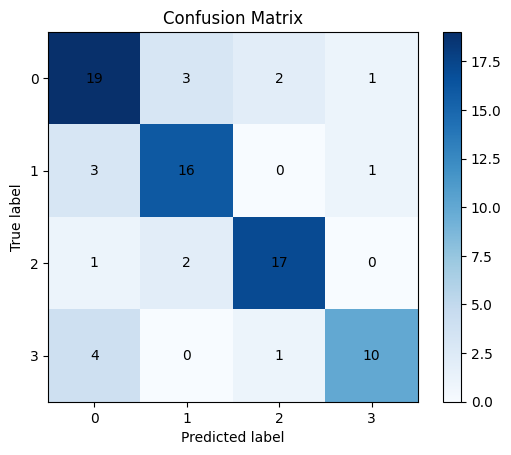

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_xgb_new, y_pred)


# plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# add numbers to the plot
for i in range(len(cm)):
    for j in range(len(cm)):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

# add labels, title, and colorbar
ax.set_xticks(np.arange(len(cm)))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(np.arange(len(cm)))
ax.set_yticklabels(np.arange(len(cm)))
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
fig.colorbar(im)
plt.show()

# KNN

In [19]:
from numpy import loadtxt
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
KNN_model = KNeighborsClassifier(n_neighbors=11)
KNN_model.fit(X_concatenated_train, y_train_xgb)

KNeighborsClassifier(n_neighbors=11)

In [20]:
KNN_y_preds = KNN_model.predict(X_concatenated_test)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, KNN_y_preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       200
           1       0.71      0.71      0.71       160
           2       0.68      0.66      0.67       160
           3       0.59      0.62      0.61       120

    accuracy                           0.66       640
   macro avg       0.66      0.66      0.66       640
weighted avg       0.66      0.66      0.66       640



In [22]:
y_pred = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = KNN_y_preds[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_pred.append(pred_label)

In [23]:
y_test_xgb_new = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = y_test_xgb[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_test_xgb_new.append(pred_label)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb_new, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67        25
           1       0.70      0.70      0.70        20
           2       0.63      0.60      0.62        20
           3       0.75      0.60      0.67        15

    accuracy                           0.66        80
   macro avg       0.68      0.66      0.66        80
weighted avg       0.67      0.66      0.66        80



#SVM

In [26]:
from numpy import loadtxt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
SVM_model = svm.SVC()
SVM_model.fit(X_concatenated_train, y_train_xgb)

SVC()

In [27]:
SVM_y_preds = SVM_model.predict(X_concatenated_test)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, SVM_y_preds))

              precision    recall  f1-score   support

           0       0.75      0.70      0.73       200
           1       0.77      0.76      0.77       160
           2       0.82      0.81      0.81       160
           3       0.62      0.72      0.67       120

    accuracy                           0.75       640
   macro avg       0.74      0.75      0.74       640
weighted avg       0.75      0.75      0.75       640



In [29]:
y_pred = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = SVM_y_preds[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_pred.append(pred_label)

In [30]:
y_test_xgb_new = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = y_test_xgb[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_test_xgb_new.append(pred_label)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb_new, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        25
           1       0.85      0.85      0.85        20
           2       0.89      0.80      0.84        20
           3       0.69      0.73      0.71        15

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.80      0.80      0.80        80



In [ ]:
# SVM 2 class

y_pred_new = np.where(np.isin(y_pred, [0, 1]), 0, 1)
y_test_new = np.where(np.isin(y_test_xgb_new, [0, 1]), 0, 1)

print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        45
           1       0.88      0.86      0.87        35

    accuracy                           0.89        80
   macro avg       0.89      0.88      0.89        80
weighted avg       0.89      0.89      0.89        80



# 2 Class classification on XGB

In [32]:


# Convert to two-class classification
y_pred_new = np.where(np.isin(y_pred, [0, 1]), 0, 1)
y_test_new = np.where(np.isin(y_test_xgb_new, [0, 1]), 0, 1)

print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        45
           1       0.88      0.86      0.87        35

    accuracy                           0.89        80
   macro avg       0.89      0.88      0.89        80
weighted avg       0.89      0.89      0.89        80



#Just local

In [36]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
# fit model no training data
# Xgb_clf = XGBClassifier()
Xgb_clf = svm.SVC()
Xgb_clf = KNeighborsClassifier(n_neighbors=11)
Xgb_clf.fit(features_local, y_train_xgb)

KNeighborsClassifier(n_neighbors=11)

In [37]:
XGB_y_preds = Xgb_clf.predict(features_local_test)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, XGB_y_preds))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       200
           1       0.66      0.66      0.66       160
           2       0.66      0.62      0.64       160
           3       0.55      0.60      0.57       120

    accuracy                           0.63       640
   macro avg       0.63      0.63      0.63       640
weighted avg       0.63      0.63      0.63       640



In [39]:
y_pred = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = XGB_y_preds[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_pred.append(pred_label)

In [40]:
y_test_xgb_new = []
for i in range(int(len(y_test_xgb)/8)):
      start = 8*i
      end = 8*i +8
      # get the labels of the current group
      group_pred = y_test_xgb[start:end]
      # use voting to predict the label of the group
      pred_label = np.argmax(np.bincount(group_pred))
      y_test_xgb_new.append(pred_label)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb_new, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.72      0.65        25
           1       0.75      0.75      0.75        20
           2       0.71      0.60      0.65        20
           3       0.62      0.53      0.57        15

    accuracy                           0.66        80
   macro avg       0.67      0.65      0.66        80
weighted avg       0.67      0.66      0.66        80

